In [1]:
import numpy as np
import torch
import warnings
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm

from contrib.differentiable_rendering.sigmoids_renderer.renderer import Renderer
from contrib.handcrafted_data import syn_dataset
from vectran.data.graphics_primitives import PrimitiveType

from crossing_refiner import CrossingRefinerFull
from utils import SyntheticPatch

DEVICE = 'cuda:1'

renderer = Renderer((64, 64), linecaps='butt', device=DEVICE, dtype=torch.float32)

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt

In [3]:
warnings.filterwarnings("ignore")
data_train = [syn_dataset[i] for i in range(100000)]
data_val = [syn_dataset[i] for i in range(20000, 30240)]

In [4]:
def make_crossing_rasters(data):
    for i, sample in enumerate(data):
        data[i]['raster'] = 1 - sample['raster']
        vectors = sample['vector'][PrimitiveType.PT_LINE]
        vectors = vectors[vectors.sum(axis=1) != 0]
        vectors[:, 5] = 0.5
        data[i]['crossing_raster'] = renderer.render(torch.from_numpy(vectors).to(DEVICE).unsqueeze(0))[0].detach().cpu().numpy()
#         data[i]['crossing_raster'] = SyntheticPatch.from_lines(vectors, default_line_rgba=(1., 1., 1., 0.5)).get_image()
#         data[i]['crossing_raster'] /= np.max(sample['crossing_raster'])
        
    return data

data_train = make_crossing_rasters(data_train)
data_val = make_crossing_rasters(data_val)

In [24]:
model = CrossingRefinerFull().to(DEVICE)
model.train(True)
criterion = torch.nn.BCEWithLogitsLoss().to(DEVICE)
mse = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

dataloader_train = DataLoader(data_train, 32, True)
dataloader_val = DataLoader(data_val, 32, False)

best_val_loss = None
best_weights = None

for epoch in range(10):
    model.train(True)
    
    for batch in tqdm(dataloader_train):
        raster = batch['raster'].unsqueeze(dim=1).float().to(DEVICE)
        crossing_raster = batch['crossing_raster'].unsqueeze(dim=1).float().to(DEVICE)

        pred = model.forward(raster)
        addition = pred
        addition = addition / addition.max(dim=3, keepdim=True).values.max(dim=2, keepdim=True).values
        output = (0.5 * addition + 0.5 * raster) * (raster > 0)
        
        loss = mse(output, crossing_raster)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    model.train(False)
        
    avg_val_loss = 0.
    n_batches = 0
    
    for batch in tqdm(dataloader_val):
        raster = batch['raster'].unsqueeze(dim=1).float().to(DEVICE)
        crossing_raster = batch['crossing_raster'].unsqueeze(dim=1).float().to(DEVICE)

        pred = model.forward(raster)
        addition = pred
        addition = addition / addition.max(dim=3, keepdim=True).values.max(dim=2, keepdim=True).values
        output = (0.5 * addition + 0.5 * raster) * (raster > 0)
        
        loss = mse(output, crossing_raster)
        
        avg_val_loss += loss.item()
        n_batches += 1
    
    avg_val_loss /= n_batches
    best_val_loss = best_val_loss or avg_val_loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        print(epoch, best_val_loss)
        torch.save(model.state_dict(), 'best_crossings_mult.pt')

  0%|          | 6/3125 [00:00<01:00, 51.59it/s]

1 0.0014593397248972907


  0%|          | 5/3125 [00:00<01:02, 49.73it/s]

2 0.0013200151906858082


  0%|          | 5/3125 [00:00<01:04, 48.43it/s]

3 0.0012773856815329054


  0%|          | 6/3125 [00:00<00:59, 52.34it/s]

4 0.0012331413930951386


  0%|          | 5/3125 [00:00<01:02, 49.88it/s]

5 0.001200484157016035


  0%|          | 6/3125 [00:00<01:01, 51.00it/s]

6 0.0011992542695224984


  0%|          | 6/3125 [00:00<01:01, 50.98it/s]

7 0.001184547828961513


100%|██████████| 320/320 [00:01<00:00, 205.09it/s]

9 0.0011544186916580656


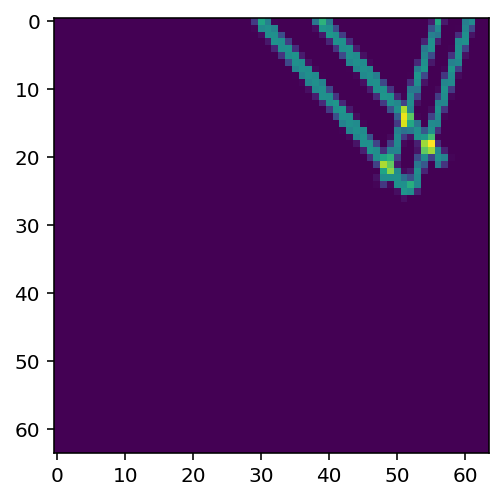

In [39]:
pred = model.forward(raster)
addition = pred
addition = addition / addition.max(dim=3, keepdim=True).values.max(dim=2, keepdim=True).values
output = (0.5 * addition + 0.5 * raster) * (raster > 0)

plt.imshow(output[25][0].detach().cpu().numpy())

In [15]:
output[0][0][0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.2488, 0.6371, 0.5155, 0.3922, 0.1000, 0.0000, 0.0000, 0.0000, 0.0902,
        0.4588, 0.5000, 0.0667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3823,
        0.6375, 0.2490, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:1', grad_fn=<SelectBackward>)

In [16]:
output[20][0].detach().cpu().numpy()

array([[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       ...,
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]], dtype=float32)

In [53]:
img = torch.sigmoid(model.forward(raster) * raster)[24][0].detach().cpu().numpy()
img -= 0.5
img /= img.max()

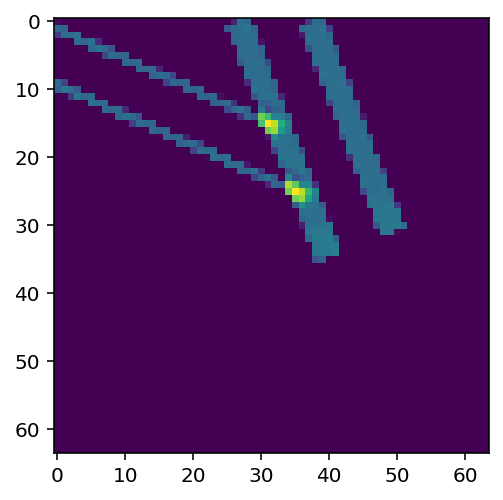

In [54]:
plt.imshow(img)

In [55]:
img

array([[0.02889483, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.3326199 , 0.32334614, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.18118736, 0.35992953, 0.36316365, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)